In [2]:
import glob, sys, os, re, numpy as np
from matplotlib import pyplot as plt
from qpms import ScatteringSystem, TMatrixInterpolator, BaseSpec, FinitePointGroup, Particle
from qpms.symmetries import point_group_info
import numpy as np
nm = 1e-9

In [4]:
#filepatterns = ['/u/46/necadam1/unix/project/AaroBECfinite_sa/Nx41_Ny42_*_ir0.npz',]

filepatterns = ['/media/necadam1/5ea6a39a-b6c0-4caf-9a43-1093e07431f0/mmn/AaroBECfinite_sa/Nx41_Ny42_*_ir0.npz',]
filenames = list()
for pattern in filepatterns:
    filenames.extend([fn for fn in glob.glob(pattern)])
nomega = len(filenames)
nomega

45

In [5]:
omegas = list()
irminima = [list() for iri in range(8)]
S_iri = [list() for iri in range(8)]
V_iri = [list() for iri in range(8)]
for filename in filenames:
    allirifilenames = [re.sub('ir0', 'ir%d'%iri, filename) for iri in range(8)]
    for iri in range(8):       
        with np.load(allirifilenames[iri]) as data:
            irminima[iri].append(data['S'][-1])
            S_iri[iri].append(data['S'])
            V_iri[iri].append(data['Vh'].conj())
            omega = data['omega'][()]
            Nx= data['Nx'][()]
            Ny = data['Ny'][()]
    omegas.append(omega)

# sort omegas to have nice plots
irminima = np.array(irminima)
omegas = np.array(omegas)
oo = np.argsort(omegas)
omegas = omegas[oo]
irminima = irminima[:,oo]
S_iri = [[S_iri[iri][i] for i in oo] for iri in range(8)]
V_iri = [[V_iri[iri][i] for i in oo] for iri in range(8)]

In [6]:
# Now we must reconstruct the scatsystem, as it has been saved nowhere
sym = FinitePointGroup(point_group_info['D2h'])
bspec = BaseSpec(lMax = 2)
tmfile = '/m/phys/project/qd/Marek/tmatrix-experiments/Cylinder/AaroBEC/cylinder_50nm_lMax4_cleaned.TMatrix'
#outputdatadir = '/home/necadam1/wrkdir/AaroBECfinite_new'
outputdatadir = '/u/46/necadam1/unix/project/AaroBECfinite_new'
os.makedirs(outputdatadir, exist_ok = True)
interp = TMatrixInterpolator(tmfile, bspec, symmetrise = sym, atol = 1e-8)

px = 571*nm; py = 621*nm

orig_x = (np.arange(Nx/2) + (0 if (Nx % 2) else .5)) * px
orig_y = (np.arange(Ny/2) + (0 if (Ny % 2) else .5)) * py

orig_xy = np.stack(np.meshgrid(orig_x, orig_y), axis = -1)

tmatrix = interp(omega)
particles = [Particle(orig_xy[i], tmatrix) for i in np.ndindex(orig_xy.shape[:-1])]


ss = ScatteringSystem(particles, sym)

positions = ss.positions()
pofs = ss.fullvec_poffsets()
ps = ss.fullvec_psizes()
irrepnames = ss.irrep_names
nirreps = ss.nirreps

In [7]:
# this is in order to use imshow etc. later
gridmap_xy_uint_pi = positions[:,:2] / np.array((px,py))
gridmap_xy_uint_pi -=  np.amin(gridmap_xy_uint_pi, axis=0)
gridmap_xy_uint_pi = gridmap_xy_uint_pi.round().astype(int)
len(gridmap_xy_uint_pi)

1722

In [8]:
threshold = 0.15
maxesarr = np.zeros((nomega, Nx, Ny))
for omi in range(nomega):
    for iri in range(nirreps):
        for i in range(len(S_iri[iri][omi])-1, -1, -1):
            if S_iri[iri][omi][i] > threshold:
                break
            Vi_full = ss.unpack_vector(V_iri[iri][omi][i], iri)
            Vi_full_grid = np.empty((Nx, Ny, len(bspec)), dtype=complex)
            for pi in range (len(gridmap_xy_uint_pi)):
                Vi_full_grid[gridmap_xy_uint_pi[pi][0],gridmap_xy_uint_pi[pi][1]] = Vi_full.reshape((Nx*Ny,len(bspec)))[pi]
            intensity = (Vi_full_grid[:,:,0]+Vi_full_grid[:,:,2]).imag
            maxesarr[omi] += abs(intensity)
            break #!!
                
            
            
                       

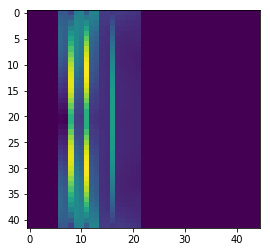

In [9]:
f, ax = plt.subplots(1, figsize = (20
                        ,4))
ax.imshow(np.sum(maxesarr, axis=1).T)
#plt.imshow(maxesarr[300])
#f.colorbar()

In [10]:
filename = filenames[1]
allirifilenames = [re.sub('ir0', 'ir%d'%iri, filename) for iri in range(8)]
print(allirifilenames)
print(filename)
with np.load(filename) as data:
    s = data['S']
    V = data['Vh'].conj()
    #k = data['k']
    omega = data['omega'][()]
    Nx = data['Nx'][()]
    Ny = data['Ny'][()]
    iri = data['iri'][()]

['/media/necadam1/5ea6a39a-b6c0-4caf-9a43-1093e07431f0/mmn/AaroBECfinite_sa/Nx41_Ny42_1.459eV_ir0.npz', '/media/necadam1/5ea6a39a-b6c0-4caf-9a43-1093e07431f0/mmn/AaroBECfinite_sa/Nx41_Ny42_1.459eV_ir1.npz', '/media/necadam1/5ea6a39a-b6c0-4caf-9a43-1093e07431f0/mmn/AaroBECfinite_sa/Nx41_Ny42_1.459eV_ir2.npz', '/media/necadam1/5ea6a39a-b6c0-4caf-9a43-1093e07431f0/mmn/AaroBECfinite_sa/Nx41_Ny42_1.459eV_ir3.npz', '/media/necadam1/5ea6a39a-b6c0-4caf-9a43-1093e07431f0/mmn/AaroBECfinite_sa/Nx41_Ny42_1.459eV_ir4.npz', '/media/necadam1/5ea6a39a-b6c0-4caf-9a43-1093e07431f0/mmn/AaroBECfinite_sa/Nx41_Ny42_1.459eV_ir5.npz', '/media/necadam1/5ea6a39a-b6c0-4caf-9a43-1093e07431f0/mmn/AaroBECfinite_sa/Nx41_Ny42_1.459eV_ir6.npz', '/media/necadam1/5ea6a39a-b6c0-4caf-9a43-1093e07431f0/mmn/AaroBECfinite_sa/Nx41_Ny42_1.459eV_ir7.npz']
/media/necadam1/5ea6a39a-b6c0-4caf-9a43-1093e07431f0/mmn/AaroBECfinite_sa/Nx41_Ny42_1.459eV_ir0.npz


In [11]:
print(iri, ss.irrep_names[iri])
i = -1
Vi_full = ss.unpack_vector(V[i], iri)
Vi_full_grid = np.empty((Nx, Ny, len(bspec)), dtype=complex)
for pi in range (len(gridmap_xy_uint_pi)):
    Vi_full_grid[gridmap_xy_uint_pi[pi][0],gridmap_xy_uint_pi[pi][1]] = Vhi_full.reshape((Nx*Ny,len(bspec)))[pi]
    
toplot = Vi_full_grid
plt.imshow((toplot[:,:,8]+toplot[:,:,10]).imag)
plt.colorbar()

0 A1'


NameError: name 'Vhi_full' is not defined

In [12]:
i=916
toplot=Vfft
plt.imshow((abs(toplot[i,:,:,0,0])+abs(toplot[i,:,:,0,2])).T)
plt.colorbar()
s[i]

NameError: name 'Vfft' is not defined

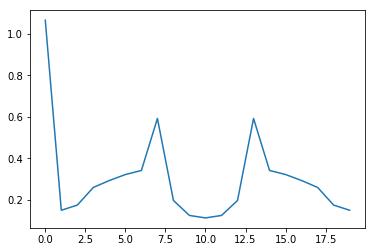

In [6]:
plt.plot(np.sum(abs(toplot[i,:,:,0,0])+abs(toplot[i,:,:,0,2]), axis=0))

In [138]:
Vfft.size

22565760

In [155]:
np.argsort(np.sum(abs(U[:,:,:,0,0])+abs(U[:,:,:,0,2]), axis=(-1,-2)))[-100:]

array([1020, 1068,  564,  613,  643,  571,  544,  611, 1100, 1036, 1037,
        639, 1004,  456,  466,  621, 1195, 1084, 1092, 1017,  478,  556,
       1105,  479, 1080, 1090,  485,  497,  879,  477,  730, 1147,  519,
        966, 1078,  851,  578, 1019,  807, 1022,  481,  435,  625,  620,
        482,  457, 1057,  638, 1032, 1073, 1014,  802,  964,  648,  439,
       1089,  769, 1072,  685, 1082,  426,  490, 1087,  574, 1060,  582,
       1083,  978,  935,  529, 1016,  520,  594,  443, 1075,  503,  916,
       1029, 1033, 1052,  467, 1031, 1101, 1071, 1010,  438,  517,  440,
        425,  572, 1103,  434, 1027, 1028,  982, 1185,  475,    2, 1025,
       1074])

In [160]:
s[np.argsort(abs(Ufft[:,0,0,0,0])+abs(Ufft[:,0,0,0,2]))[-100:]]

array([2.61022236e-01, 8.73308428e-02, 1.64466336e-02, 2.31822293e-01,
       1.63222844e-01, 1.03544218e-01, 2.52342759e-01, 2.42886690e-01,
       1.61043921e-01, 1.07902078e-01, 3.08800610e-02, 2.85826833e-01,
       1.65510757e-02, 3.11904536e-03, 2.65033317e-01, 2.74439759e-01,
       1.42553114e-01, 1.24143354e-01, 1.82118771e-01, 1.31085645e-01,
       1.58651573e-01, 1.44033330e-01, 1.31871981e-02, 2.66221007e-01,
       1.08484094e-01, 2.11863367e-01, 2.38216064e-02, 1.52979438e-01,
       1.32417079e-01, 1.64438069e-01, 2.62714840e-01, 2.53777092e-02,
       1.89693138e-01, 1.00743197e-01, 8.50864066e-02, 3.88029069e-02,
       1.36099555e-01, 1.17010025e-01, 1.11188431e-01, 4.42183532e-02,
       3.49927701e-01, 5.04169994e-02, 2.48399791e-02, 1.20953558e-01,
       1.09475534e-01, 2.76938471e-01, 1.25775641e-01, 1.12683405e-01,
       2.05150213e-01, 2.96075321e-01, 4.10003639e-02, 1.49393322e-01,
       2.54854559e-01, 1.06115414e-01, 2.16793732e-01, 1.29883630e-01,
      

(0, 1)

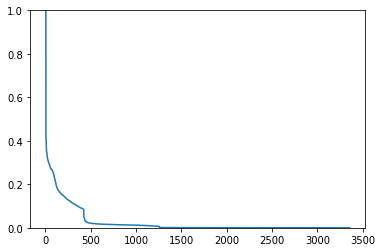

In [140]:
plt.plot(s)
plt.ylim([0,1])

In [141]:
s[-1]

3.6187828360761144e-07

In [154]:
s[-5]

1.5750323600117863e-06

In [31]:
len(bspec)

16

In [66]:
Vh.shape

(840, 840)

In [14]:
Nx = 40
Ny = 43

In [71]:
irrepnames

["A1'", "A1''", "A2'", "A2''", "B1'", "B1''", "B2'", "B2''"]